# PySpark Data Cleaning & Analysis on MovieLens Dataset

In this project, I utilized the capabilities of PySpark to perform data cleaning and exploratory data analysis on the MovieLens 100K dataset. The primary objective was to understand the distribution of ratings, particularly focusing on the horror genre

Data Sources Used:

MovieLens 100K Dataset: This dataset, provided by GroupLens, comprises 100,000 ratings from 943 users on 1682 movies. It contains detailed ratings data, along with user demographics and movie metadata. Specific files used from this dataset include:
 - u.data: Contains the full dataset of user ratings.
 - u.item: Holds movie metadata, including titles and genres

In [1]:
from pyspark.sql import SparkSession

# Initializing a Spark session
spark = SparkSession.builder.appName("MovieLensDataCleaning").getOrCreate()

In [2]:
# Defining the paths to the datasets
ratings_data_path = "u.data"
movie_data_path = "u.item"

In [3]:
# Loading the ratings dataset into a DataFrame (renaming based on documentation provided by MovieLens 100K dataset)
ratings_df = spark.read.csv(ratings_data_path, sep="\t", header=False)
ratings_df = ratings_df.withColumnRenamed("_c0", "user_id") \
                       .withColumnRenamed("_c1", "movie_id") \
                       .withColumnRenamed("_c2", "rating") \
                       .withColumnRenamed("_c3", "timestamp")

In [4]:
# Displaing the first few rows
ratings_df.show()

+-------+--------+------+---------+
|user_id|movie_id|rating|timestamp|
+-------+--------+------+---------+
|    196|     242|     3|881250949|
|    186|     302|     3|891717742|
|     22|     377|     1|878887116|
|    244|      51|     2|880606923|
|    166|     346|     1|886397596|
|    298|     474|     4|884182806|
|    115|     265|     2|881171488|
|    253|     465|     5|891628467|
|    305|     451|     3|886324817|
|      6|      86|     3|883603013|
|     62|     257|     2|879372434|
|    286|    1014|     5|879781125|
|    200|     222|     5|876042340|
|    210|      40|     3|891035994|
|    224|      29|     3|888104457|
|    303|     785|     3|879485318|
|    122|     387|     5|879270459|
|    194|     274|     2|879539794|
|    291|    1042|     4|874834944|
|    234|    1184|     2|892079237|
+-------+--------+------+---------+
only showing top 20 rows



In [5]:
#Viewing the dataset schema
ratings_df.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- movie_id: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- timestamp: string (nullable = true)



In [6]:
#Extracting statistics
ratings_df.describe().show()

+-------+------------------+------------------+------------------+-----------------+
|summary|           user_id|          movie_id|            rating|        timestamp|
+-------+------------------+------------------+------------------+-----------------+
|  count|            100000|            100000|            100000|           100000|
|   mean|         462.48475|         425.53013|           3.52986|8.8352885148862E8|
| stddev|266.61442012750905|330.79835632558473|1.1256735991443214|5343856.189502848|
|    min|                 1|                 1|                 1|        874724710|
|    max|                99|               999|                 5|        893286638|
+-------+------------------+------------------+------------------+-----------------+



In [7]:
#Checking for missing values
from pyspark.sql.functions import col, sum

ratings_df.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in ratings_df.columns)).show()

+-------+--------+------+---------+
|user_id|movie_id|rating|timestamp|
+-------+--------+------+---------+
|      0|       0|     0|        0|
+-------+--------+------+---------+



In [8]:
#Checking for duplicates
duplicate_rows = ratings_df.count() - ratings_df.distinct().count()

#Dropping duplicates if present
if duplicate_rows > 0:
    ratings_df = ratings_df.dropDuplicates()
    
duplicate_rows

0

In [9]:
#Checking for ratings outside the 1-5 range
ratings_df.filter(~col("rating").between(1, 5)).show()

+-------+--------+------+---------+
|user_id|movie_id|rating|timestamp|
+-------+--------+------+---------+
+-------+--------+------+---------+



In [10]:
ratings_df.head(5)

[Row(user_id='196', movie_id='242', rating='3', timestamp='881250949'),
 Row(user_id='186', movie_id='302', rating='3', timestamp='891717742'),
 Row(user_id='22', movie_id='377', rating='1', timestamp='878887116'),
 Row(user_id='244', movie_id='51', rating='2', timestamp='880606923'),
 Row(user_id='166', movie_id='346', rating='1', timestamp='886397596')]

In [11]:
#Calculating user metrics
from pyspark.sql.functions import avg, count

user_metrics = ratings_df.groupBy("user_id").agg(
    avg("rating").alias("avg_rating"),
    count("movie_id").alias("total_movies_rated")
)

user_metrics.show()

+-------+------------------+------------------+
|user_id|        avg_rating|total_movies_rated|
+-------+------------------+------------------+
|    296|4.1768707482993195|               147|
|    467|3.6818181818181817|                44|
|    691|           4.21875|                32|
|    675|3.7058823529411766|                34|
|    829|          3.546875|                64|
|    125|3.4395604395604398|               182|
|    451|2.7346938775510203|                98|
|    800|              3.75|                28|
|    853| 2.975609756097561|                41|
|    666|3.6653061224489796|               245|
|    870| 3.453531598513011|               269|
|    919|3.4700460829493087|               217|
|    926|               3.3|                20|
|      7| 3.965260545905707|               403|
|    124|               3.5|                24|
|     51|3.5652173913043477|                23|
|    447| 3.597122302158273|               139|
|    591|3.6547619047619047|            

In [12]:
#Setting the minimun number of ratings per movie for forther investigation
min_ratings = 50

#Aggregating ratings by movie
movie_ratings = ratings_df.groupBy("movie_id").agg(
    avg("rating").alias("avg_rating"),
    count("rating").alias("num_ratings")
)

#Filtering movies with ratings above the threshold and sorting them by average rating
top_movies = movie_ratings.filter(movie_ratings.num_ratings > min_ratings).orderBy("avg_rating", ascending=False)

top_movies.show()

+--------+------------------+-----------+
|movie_id|        avg_rating|num_ratings|
+--------+------------------+-----------+
|     408| 4.491071428571429|        112|
|     318| 4.466442953020135|        298|
|     169| 4.466101694915254|        118|
|     483|  4.45679012345679|        243|
|     114| 4.447761194029851|         67|
|      64| 4.445229681978798|        283|
|     603|4.3875598086124405|        209|
|      12| 4.385767790262173|        267|
|      50|4.3584905660377355|        583|
|     178|             4.344|        125|
|     513| 4.333333333333333|         72|
|     134| 4.292929292929293|        198|
|     427| 4.292237442922374|        219|
|     357| 4.291666666666667|        264|
|      98|  4.28974358974359|        390|
|     480| 4.284916201117318|        179|
|     127| 4.283292978208232|        413|
|     285| 4.265432098765432|        162|
|     272| 4.262626262626263|        198|
|     657| 4.259541984732825|        131|
+--------+------------------+-----

In [13]:
#Finding out who is the most active user..
most_active_users = user_metrics.orderBy("total_movies_rated", ascending=False)
most_active_users.show()

+-------+------------------+------------------+
|user_id|        avg_rating|total_movies_rated|
+-------+------------------+------------------+
|    405|1.8344640434192674|               737|
|    655| 2.908029197080292|               685|
|     13|  3.09748427672956|               636|
|    450|3.8648148148148147|               540|
|    276| 3.465250965250965|               518|
|    416| 3.845841784989858|               493|
|    537|2.8653061224489798|               490|
|    303| 3.365702479338843|               484|
|    234| 3.122916666666667|               480|
|    393|3.3370535714285716|               448|
|    181|1.4919540229885058|               435|
|    279|3.2672811059907834|               434|
|    429| 3.393719806763285|               414|
|    846| 3.740740740740741|               405|
|      7| 3.965260545905707|               403|
|     94|            3.6575|               400|
|    682| 3.137844611528822|               399|
|    308|3.7581863979848866|            

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

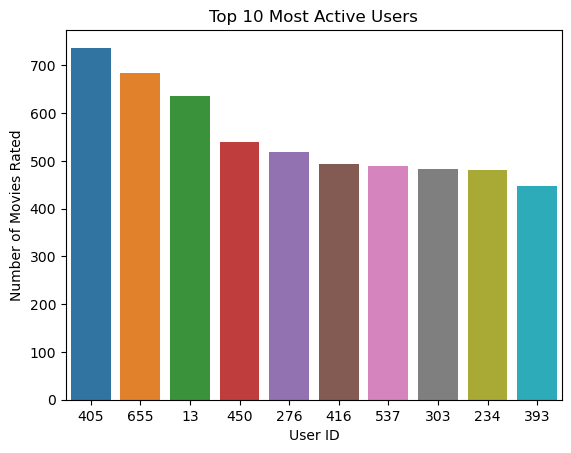

In [15]:
#Geting top 10 active users

top_users_pd = most_active_users.limit(10).toPandas()

#Let's take a look..
sns.barplot(x='user_id', y='total_movies_rated', data=top_users_pd)
plt.title(f'Top {10} Most Active Users')
plt.xlabel('User ID')
plt.ylabel('Number of Movies Rated')
plt.show()

In [16]:
#Loading the movie data into a DataFrame
movies_df = spark.read.csv(movie_data_path, sep="|", header=False, encoding="ISO-8859-1")
movies_df = movies_df.withColumnRenamed("_c0", "movie_id") \
                     .withColumnRenamed("_c1", "title")

In [17]:
#Prepering the genre list based on MovieLens 100K documentation, which specifies the order and names of genres eg. _c5, _c6 atd..
genre_columns = ["Unknown", "Action", "Adventure", "Animation", "Children's", "Comedy", "Crime", "Documentary", "Drama", "Fantasy", 
                 "Film-Noir", "Horror", "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"]
for idx, genre in enumerate(genre_columns, 5):
    movies_df = movies_df.withColumnRenamed(f"_c{idx}", genre)

#Displaing the first 5 rows..
movies_df.select("movie_id", "title", "Horror").show(5)

+--------+-----------------+------+
|movie_id|            title|Horror|
+--------+-----------------+------+
|       1| Toy Story (1995)|     0|
|       2| GoldenEye (1995)|     0|
|       3|Four Rooms (1995)|     0|
|       4|Get Shorty (1995)|     0|
|       5|   Copycat (1995)|     0|
+--------+-----------------+------+
only showing top 5 rows



In [18]:
# Joining the data
joined_df = ratings_df.join(movies_df, on="movie_id", how="inner")

#Only horror movies matter..
horror_df = joined_df.filter(joined_df.Horror == 1)

#Calculating ratings distribution for horror movies
horror_rating_distribution = horror_df.groupBy("rating").agg(
    count("rating").alias("count")
).orderBy("rating")

horror_rating_distribution.show()

+------+-----+
|rating|count|
+------+-----+
|     1|  503|
|     2|  814|
|     3| 1513|
|     4| 1610|
|     5|  877|
+------+-----+



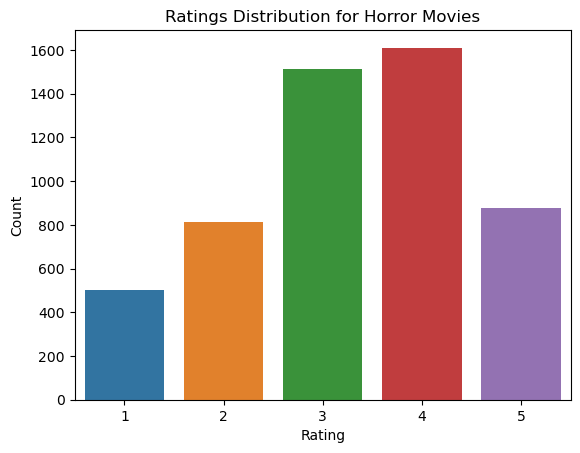

In [21]:
#What are the ratings distribiutions for horror movies?
horror_ratings_pd = horror_rating_distribution.toPandas()

#Ploting
sns.barplot(x='rating', y='count', data=horror_ratings_pd)
plt.title('Ratings Distribution for Horror Movies')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

Personal note: Horror movies are definitely receiving a lot of 1-star ratings, which suggests that this genre is quite underrated... :C